<a href="https://colab.research.google.com/github/anandvardhanit84/GenerativeAI/blob/main/news_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import numpy as np
import pandas as pd
import re
from time import time
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import tensorflow as tf
from keras import backend as K
import gensim
from numpy import *
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import concurrent.futures

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
summary = pd.read_csv('/content/drive/MyDrive/news-summarization/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/content/drive/MyDrive/news-summarization/news_summary_more.csv', encoding='iso-8859-1')

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
NUM_THREADS = 4

In [ ]:
pre_data1 =  raw.iloc[:,0:2].copy()

pre_data2 = summary.iloc[:,0:6].copy()
pre_data2['text'] = pre_data2['author'].str.cat(pre_data2['date'].str.cat(pre_data2['read_more'].str.cat(pre_data2['text'].str.cat(pre_data2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")
pre_data = pd.DataFrame()
pre_data['text'] = pd.concat([pre_data1['text'], pre_data2['text']], ignore_index=True)
pre_data['summary'] = pd.concat([pre_data1['headlines'],pre_data2['headlines']],ignore_index = True)

pre_data['text'][:10]


0    Saurav Kant  an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan  customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

In [ ]:
def process_doc(doc):
    return str(doc)

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:

        row=re.sub("(\\t)", ' ', str(row)).lower() #delete escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower()
        row=re.sub("(\\n)", ' ', str(row)).lower()

        row=re.sub("(__+)", ' ', str(row)).lower()   #delete _ if more than one time repeatedly
        row=re.sub("(--+)", ' ', str(row)).lower()   #delete - if more than one time repeatedly
        row=re.sub("(~~+)", ' ', str(row)).lower()   #delete ~ if more than one time repeatedly
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #delete + if more than one time repeatedly
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #delete . if more than one time repeatedly

        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #delete <>()|&©ø"',;?~*!

        row=re.sub("(mailto:)", ' ', str(row)).lower() #delete mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #delete \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM


        row=re.sub("(\.\s+)", ' ', str(row)).lower() #delete full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #delete - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #delete : at end of words(not between)

        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #delete any single charecters hanging between 2 spaces

        # Change url http://www.youtube.com/watch/43865346kcre8375 ====> www.youtube.com
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them

        row = re.sub("(\s+)",' ',str(row)).lower() #delete multiple spaces
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #delete any single charecters hanging between 2 spaces

        yield row

cleaning1 = text_strip(pre_data['text'])
cleaning2 = text_strip(pre_data['summary'])

t = time()
print(t)
# Process documents in batches using parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
    text = list(executor.map(process_doc, nlp.pipe(cleaning1, batch_size=500)))
#text = [str(doc) for doc in nlp.pipe(cleaning1, batch_size=5000)]  # Remove n_threads argument
  #Takes 40 mins
print('11')
print('Cleaning time for text: {} mins'.format(round((time() - t) / 60, 2)))

t = time()

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(cleaning2, batch_size=5000)]  # Remove n_threads argument

  #Takes 40 mins
print('Cleaning time for summary: {} mins'.format(round((time() - t) / 60, 2)))
text[0]
summary[0]

1709711424.5003374
11
Cleaning time for text: 2.53 mins
Cleaning time for summary: 0.14 mins


'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [ ]:
#Save the clean data to files
with open('text.txt', "w", encoding="utf-8") as f:
    for item in text:
        f.write(item + '\n')

with open('summary.txt', "w", encoding="utf-8") as f:
    for item in summary:
        f.write(item + '\n')

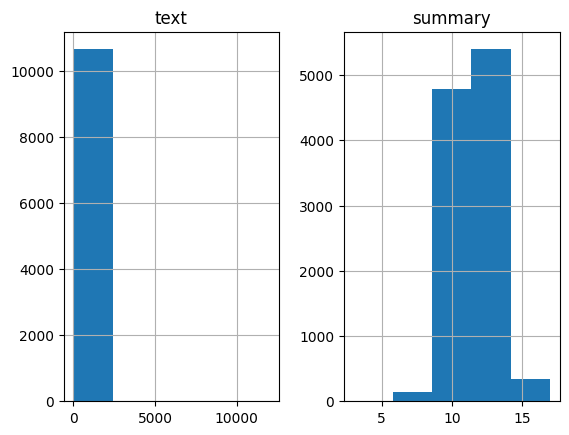

0.9934413941722102
0.593460133046004
% of rare words in vocabulary: 65.31593712428196
Total Coverage of rare words: 6.81707050795125
Size of vocabulary in X = 7790
% of rare words in vocabulary: 82.23124516627996
Total Coverage of rare words: 18.51824097318496
Size of vocabulary in Y = 1839


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 200)             1558000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 100, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [ ]:
#Read clean data from files
text1 = []
summary1 = []
text = []
summary = []

with open('text.txt', "r", encoding="utf-8") as f:
    for line in f.readlines():
        text1.append(line)

with open('summary.txt', "r", encoding="utf-8") as f:
    for line in f.readlines():
        summary1.append(line)

for item in text1:
    text.append(item.replace('\n', ''))

for item in summary1:
    summary.append(item.replace('\n', ''))

pre_data['cleaned_text'] = pd.Series(text)
pre_data['cleaned_summary'] = pd.Series(summary)

text_count = []
summary_count = []

for sent in pre_data['cleaned_text']:
    text_count.append(len(sent.split()))

for sent in pre_data['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

graph_df.hist(bins = 5)
plt.show()

#Check how much % of summary have 0-15 words
count=0
for i in pre_data['cleaned_summary']:
    if(len(i.split())<=15):
        count=count+1
print(count/len(pre_data['cleaned_summary']))

#Check how much % of text have 0-70 words
count=0
for i in pre_data['cleaned_text']:
    if(len(i.split())<=100):
        count=count+1
print(count/len(pre_data['cleaned_text']))

#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

#Select the Summaries and Text between max len defined above
cleaned_text =np.array(pre_data['cleaned_text'])
cleaned_summary=np.array(pre_data['cleaned_summary'])
short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre_data=pd.DataFrame({'text':short_text,'summary':short_summary})
post_pre_data.head(2)

#Add sostok and eostok at
post_pre_data['summary'] = post_pre_data['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
post_pre_data.head(2)

x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre_data['text']),np.array(post_pre_data['summary']),test_size=0.1,random_state=0,shuffle=True)

#Lets tokenize the text to get the vocab count , you can use Spacy here also
#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer()
x_tknizer.fit_on_texts(list(x_tr))

thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in x_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value

print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer(num_words=total_count-count)
x_tknizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tknizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tknizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tknizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer()
y_tknizer.fit_on_texts(list(y_tr))

thresh=6
count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value

print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer(num_words=total_count-count)
y_tknizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tknizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tknizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tknizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

#We will now delete "Summary" i.e Y (both train and val) which has only START and END

ind=[]
for i in range(len(y_tr)):
    count=0
    for j in y_tr[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    count=0
    for j in y_val[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer - softmax
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

#Start fitting the model with the data




In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

#Save model weights
model.save_weights('fitted_model')



Epoch 1/30
45/45 [==============================] - 62s 1s/step - loss: 4.9106 - val_loss: 4.0744
Epoch 2/30
45/45 [==============================] - 50s 1s/step - loss: 4.1668 - val_loss: 3.9614
Epoch 3/30
45/45 [==============================] - 48s 1s/step - loss: 3.9757 - val_loss: 3.8642
Epoch 4/30
45/45 [==============================] - 46s 1s/step - loss: 3.7826 - val_loss: 3.5999
Epoch 5/30
45/45 [==============================] - 48s 1s/step - loss: 3.7100 - val_loss: 3.5507
Epoch 6/30
45/45 [==============================] - 46s 1s/step - loss: 3.6876 - val_loss: 3.5486
Epoch 7/30
45/45 [==============================] - 47s 1s/step - loss: 3.6771 - val_loss: 3.5368
Epoch 8/30
45/45 [==============================] - 45s 1s/step - loss: 3.6671 - val_loss: 3.5350
Epoch 9/30
45/45 [==============================] - 47s 1s/step - loss: 3.6590 - val_loss: 3.5331
Epoch 10/30
45/45 [==============================] - 45s 1s/step - loss: 3.6515 - val_loss: 3.5384
Epoch 11/30
45/45 [

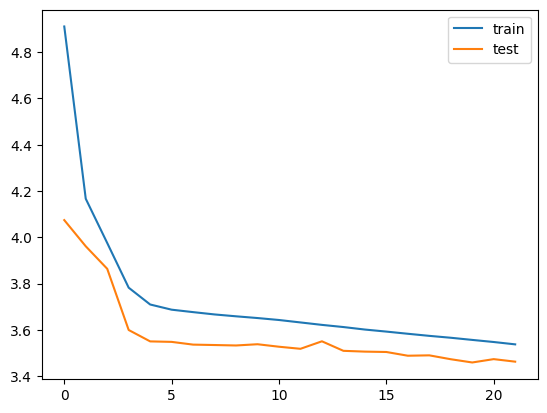

Review: india defeated new zealand by wickets in the third odi today to take an 3 0 lead in the five match series this is the first time since 2009 that india have won an odi series in new zealand virat kohli became only the second captain after ms dhoni to lead india to an odi series victory in new zealand 
Original summary:  india win an odi series in new zealand after 10 years  
1/1 [==============================] - 0s 20ms/step
Predicted summary:   us to be in 


Review: the value of apple stake held by billionaire has fallen by over 22 billion in the last months more than 5 stake in the iphone maker is now valued at about 36 billion last may the world third richest person said he love to see apple shares decline in price so he could buy more 
Original summary:  apple stake value falls by 22 billion in months  
1/1 [==============================] - 0s 19ms/step
Predicted summary:   us to be in 


Review: smriti mandhana and mithali raj scored unbeaten fifties while goswami regist

In [ ]:
#Load model weights
model = model.load_weights('fitted_model')

#Plot model learning curve
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

reverse_target_word_index=y_tknizer.index_word
reverse_source_word_index=x_tknizer.index_word
target_word_index=y_tknizer.word_index

# Encoding our input seq for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
dec_emb2= dec_emb_layer(decoder_inputs)
# initial states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# softmax for probability
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
# Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString



In [1]:
#Predict and print summaries from model
for i in range(0,10):
    print("Review:",sequence_to_text(x_tr[i]))
    print("summary:",(sequence_to_summary(y_tr[i])).replace('start', '').replace('end', ''))
    print("Predicted summary:",(decode_sequence(x_tr[i].reshape(1,max_text_len))).replace('start', '').replace('end', ''))
    print("\n")

def calculate_BLEU(N=100):
    bscore=0;gscore=0;mscore=0
    for i in range(N):
        ref=sequence_to_summary(y_tr[i])
        hypo=decode_sequence(x_tr[i].reshape(1,max_text_len))
        bscore+=sentence_bleu([ref],hypo)
    print("BLEU:%.4f GLEU:%.4f METEOR:%.4f"%(bscore/N,gscore/N,mscore/N))

calculate_BLEU()

NameError: name 'sequence_to_text' is not defined